In [1]:
import torchvision
import os, sys
import argparse
import numpy as np
from collections import defaultdict
import json
import time
import multiprocessing
import copy
import os
import os.path as osp
# from utils import IdGenerator, id2rgb
import pdb
import torch
import numpy as np
try:
    import PIL.Image     as Image
except:
    print("Failed to import the image processing packages.")
    sys.exit(-1)
from pycocotools.coco import COCO
import numpy as np
# import skimage.io as io

import random
import numpy as np
import itertools as it
import torch
import torchvision
import json
import bisect
import copy


In [3]:
def _quantize(x, bins):
    bins = copy.copy(bins)
    bins = sorted(bins)
    quantized = list(map(lambda y: bisect.bisect_right(bins, y), x))
    return quantized


min_keypoints_per_image = 10


def _count_visible_keypoints(anno):
    return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)


def _has_only_empty_bbox(anno):
    return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)


def has_valid_annotation(anno):
    # if it's empty, there is no annotation
    if len(anno) == 0:
        return False
    # if all boxes have close to zero area, there is no annotation
    if _has_only_empty_bbox(anno):
        return False
    # keypoints task have a slight different critera for considering
    # if an annotation is valid
    if "keypoints" not in anno[0]:
        return True
    # for keypoint detection tasks, only consider valid images those
    # containing at least min_keypoints_per_image
    if _count_visible_keypoints(anno) >= min_keypoints_per_image:
        return True
    return False

class COCODataset(torchvision.datasets.coco.CocoDetection):
    def __init__(self, root, ann_file, sorted_id=id_step1, remove_images_without_annotations=False):
        super(COCODataset, self).__init__(root, ann_file)
        self.ids = sorted(self.ids)

        # filter images without detection annotations
        if remove_images_without_annotations:
            ids = []
            for img_id in self.ids:
                ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds = sorted_id,iscrowd=None)
#                 ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)

                anno = self.coco.loadAnns(ann_ids)
                if has_valid_annotation(anno):
                    ids.append(img_id)
            self.ids = ids

        self.categories = {cat['id']: cat['name'] for cat in self.coco.cats.values()}

        self.category_id_to_sorted_id = {
            v: i + 1 for i, v in enumerate(sorted_id)
        }
        self.sorted_id_to_category_id = {
            v: k for k, v in self.category_id_to_sorted_id.items()
        }
        self.id_to_img_map = {k: v for k, v in enumerate(self.ids)}
        self.img_map_to_id = {v: k for k, v in self.id_to_img_map.items()}

#         self._transforms = transforms
        
    def __getitem__(self, idx):
        img, anno = super(COCODataset, self).__getitem__(idx)
#         print(anno)
        return img, anno, idx
    
    def get_img_info(self, index):
        img_id = self.id_to_img_map[index]
        img_data = self.coco.imgs[img_id]
        return img_data

In [4]:
len(id_step1[-nStep:])

160

In [7]:
save_path = '/mnt/data-disk2/xinting/project/dataset/LVIS/lvis_trainval_1230/lvis_step1_160'
data_path = '/mnt/data-disk2/xinting/project/dataset/LVIS/lvis_trainval_1230/lvis_step1_2'
# os.mkdir(save_path)
sorted_cls_id_file = os.path.join(data_path,'lvis_sorted_id_step1.json')
with open(sorted_cls_id_file, 'r') as f:
    sorted_cls_id = json.load(f)
    
train_step1_json_file = data_path + "/lvis_v0.5_train_step1.json"
train_data_path = './dataset/LVIS/images/train2017'

with open(train_step1_json_file, 'r') as f:
    train_step1 = json.load(f)


In [17]:
nBase = 270
nAccum = 20
nGpu = 8 
nStep = 160
nIter = 100
Step = 1

id_step1 = sorted_cls_id[:nBase+nStep*Step]
coco_step1 = COCODataset(train_data_path, train_step1_json_file, id_step1, True)

loading annotations into memory...
Done (t=13.11s)
creating index...
index created!


In [18]:
train_images_step1 = []
train_images_per_c_step1 = []
for class_i in id_step1:
    img_ids_cls_i_wo_select = coco_step1.coco.getImgIds(catIds=class_i)
    img_ids_cls_i = []
    for img_id_cls_i in img_ids_cls_i_wo_select:
        ann_ids = coco_step1.coco.getAnnIds(imgIds=img_id_cls_i, catIds = class_i,iscrowd=None)
#                 ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anno = coco_step1.coco.loadAnns(ann_ids)
#         print(anno)
        if has_valid_annotation(anno):
            img_ids_cls_i.append(img_id_cls_i)
        else:
            print(img_id_cls_i)
#     if class_i in id_step1[-nStep:]:
#         img_ids_cls_i = list(set(img_ids_cls_i).intersection((set(coco_train_tail.ids))))
    train_images_step1.extend(img_ids_cls_i)
    train_images_per_c_step1.append(img_ids_cls_i)

tail_idx_step1 = list(range(nBase+nStep*(Step-1),nBase+nStep*Step))
tail_images_step1 = []
all_tail_images_step1 = []
for idx_c in tail_idx_step1:    
    tail_images_step1.append([coco_step1.img_map_to_id[idx] for idx in train_images_per_c_step1[idx_c]])
    all_tail_images_step1.extend([coco_step1.img_map_to_id[idx] for idx in train_images_per_c_step1[idx_c]])

In [19]:
print('images number:',len(all_tail_images_step1))

images number: 16349


## construct random sample indices_qry:

In [59]:
nIterAll = 160000
total_iteration = nIterAll
all_tail_images_step1 = []
for tail_image_step1 in tail_images_step1:
    all_tail_images_step1.extend(tail_image_step1)
all_tail_images_step1 = list(np.unique(np.array(all_tail_images_step1)))
epochs = int(np.floor(total_iteration/len(all_tail_images_step1)))
iter_img_id = []
for epoch in range(epochs):
    g = torch.Generator()
    g.manual_seed(epoch)
    index_i = torch.randperm(len(all_tail_images_step1), generator=g).tolist()
    img_id_i = [all_tail_images_step1[index] for index in index_i]
    iter_img_id.extend(img_id_i)
iter_img_id += all_tail_images_step1[: (total_iteration - len(iter_img_id))]


iter_img_id_reshape = np.array(iter_img_id).reshape((nGpu, -1))
iter_img_id_qry = iter_img_id_reshape.tolist()
# json.dump(iter_img_id_qry, open(os.path.join(save_path, 'lvis_indices_qry_step1_rand.json'), 'w'))


In [ ]:
# 查看每个类的instance个数
ids = []
ids_len = []
ann_num = [0] *len(id_step1)

for index, class_i in enumerate(id_step1):
    ids_i = []
    for img_id in all_tail_images_step1:
        ann_ids = coco_step1.coco.getAnnIds(imgIds=coco_step1.id_to_img_map[img_id], catIds = class_i,iscrowd=None)    
        anno = coco_step1.coco.loadAnns(ann_ids)
        ann_num[index] += len(anno)
        if has_valid_annotation(anno):
            ids_i.append(img_id)
    ids.append(ids_i)
    ids_len.append(len(ids_i))

In [ ]:
import matplotlib
%matplotlib inline
import pylab
import matplotlib.pyplot as plt
from matplotlib.ticker import  MultipleLocator
# matplotlib.use('Agg')

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
pylab.rcParams['figure.figsize'] = (20.0, 7.0)

x=range(len(id_step1))[100:]
y=ann_num[100:]

fig = plt.figure()
ax = fig.gca()

ymajorLocator = MultipleLocator(300)     
yminorLocator = MultipleLocator(150)       
ax.yaxis.set_major_locator(ymajorLocator)       
ax.yaxis.set_minor_locator(yminorLocator)

plt.plot(x,y, linewidth=3.0)

# plt.yscale('log') #choose log or not
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# 设置坐标标签字体大小

font1 = {'family':'serif','weight': 'normal','size': 28}
ax.set_xlabel('Sorted category index', font1)
ax.set_ylabel('Number of instances', font1)
# plt.legend(frameon=False)

plt.grid(linestyle='-.',which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细

## construct balnced indices_qry:

In [28]:
all_tail_images_step1 = []
all_tail_classes_step1 = []
for tail_id, tail_image_step1 in enumerate(tail_images_step1):
    all_tail_images_step1.extend(tail_image_step1)
    all_tail_classes_step1.extend([nBase + nStep*(Step-1)+tail_id+1]*len(tail_image_step1))

In [29]:
ids = []
ids_len = []
ann_num_all_dataset = [0] *len(id_step1)

for index, class_i in enumerate(id_step1):
    ids_i = []
    for img_id in coco_train.ids:
        ann_ids = coco_train.coco.getAnnIds(imgIds=img_id, catIds = class_i,iscrowd=None)    
        anno = coco_train.coco.loadAnns(ann_ids)
        ann_num_all_dataset[index] += len(anno)
        if has_valid_annotation(anno):
            ids_i.append(img_id)
    ids.append(ids_i)
    ids_len.append(len(ids_i))

In [30]:
avg_num_per_img = np.array(ann_num_all_dataset)/np.array(ids_len)
avg_sample_num = np.round(np.mean(ann_num_all_dataset[-nStep:])/avg_num_per_img)[:nBase+nStep*(Step-1)]


In [32]:
len(np.unique(np.array(all_tail_images_step1)))

12852

In [33]:
print(len(all_tail_images_step1))

16349


In [34]:
len(all_tail_images_step1)+int(sum(avg_sample_num))

41499

In [35]:
nIter = 160000
nGpu=4
total_iteration = nIter*nGpu
epochs = int(np.floor(total_iteration/(len(all_tail_images_step1)+int(sum(avg_sample_num)))))
iter_img_id = []
iter_cls_id = []
for epoch in range(epochs):
    
    replay_indices_step1 = []
    
    g = torch.Generator()
    g.manual_seed(epoch)
    
    
    replay_images_step1=[]
    replay_images_imgid_step1=[]
    
    for i in range(nBase+nStep*(Step-1)):
        train_images_i_id = [coco_step1.img_map_to_id[idx] for idx in train_images_per_c_step1[i]]
        if int(avg_sample_num[i]) == 0:
            avg_sample_num[i] = 1
#         index_i = torch.randperm(len(train_images_i_id), generator=g).tolist()[:int(avg_sample_num[i])]
        index_i = torch.randint(0, len(train_images_i_id), (int(avg_sample_num[i]),1), generator=g).squeeze(1).tolist()
        img_id_replay_i = np.array(train_images_i_id)[index_i] 
        train_images_i = np.array(train_images_per_c_step1[i])[index_i]
        
        replay_indices_step1.extend([i+1]*int(avg_sample_num[i]))
        replay_images_step1.extend(img_id_replay_i.tolist())   
        replay_images_imgid_step1.append(train_images_i.tolist())
#         print(replay_indices_step1)
    
    
    all_balance_images_step1 = all_tail_images_step1 + replay_images_step1
    all_balance_classes_step1 = all_tail_classes_step1 + replay_indices_step1
#     print(len(all_balance_images_step1))
#     print(len(all_balance_classes_step1))
    
    index_i = torch.randperm(len(all_balance_images_step1), generator=g).tolist()
    img_id_i = [all_balance_images_step1[index] for index in index_i]
    cls_id_i = [all_balance_classes_step1[index] for index in index_i]
    iter_img_id.extend(img_id_i)
    iter_cls_id.extend(cls_id_i)
#     print(len(iter_cls_id))
#     print(len(iter_img_id))
# print(len(iter_cls_id))
# print(len(iter_img_id))
iter_img_id += all_balance_images_step1[: (total_iteration - len(iter_img_id))]
iter_cls_id += all_balance_classes_step1[: (total_iteration - len(iter_cls_id))]

iter_img_id_reshape = np.array(iter_img_id).reshape((nGpu, nIter))
iter_cls_id_reshape = np.array(iter_cls_id).reshape((nGpu, nIter))
iter_img_id_balanced_qry = iter_img_id_reshape.tolist()
iter_cls_id_balanced_qry = iter_cls_id_reshape.tolist()




In [36]:
len(np.unique(iter_img_id_balanced_qry[0]))

40981

In [54]:
len_epoch = len(all_tail_images_step1)+int(sum(avg_sample_num))
ann_num_balanced = [0]*(nBase + nStep*Step)
for idx, img in zip(iter_cls_id_reshape[1][len_epoch*0:len_epoch*4], iter_img_id_reshape[1][len_epoch*0:len_epoch*4]):
    class_i = id_step1[idx-1]
    ann_ids = coco_step1.coco.getAnnIds(imgIds=coco_step1.id_to_img_map[img], catIds = class_i,iscrowd=None)    
    anno = coco_step1.coco.loadAnns(ann_ids)
    ann_num_balanced[idx-1] += len(anno)

In [55]:
len_epoch

41499

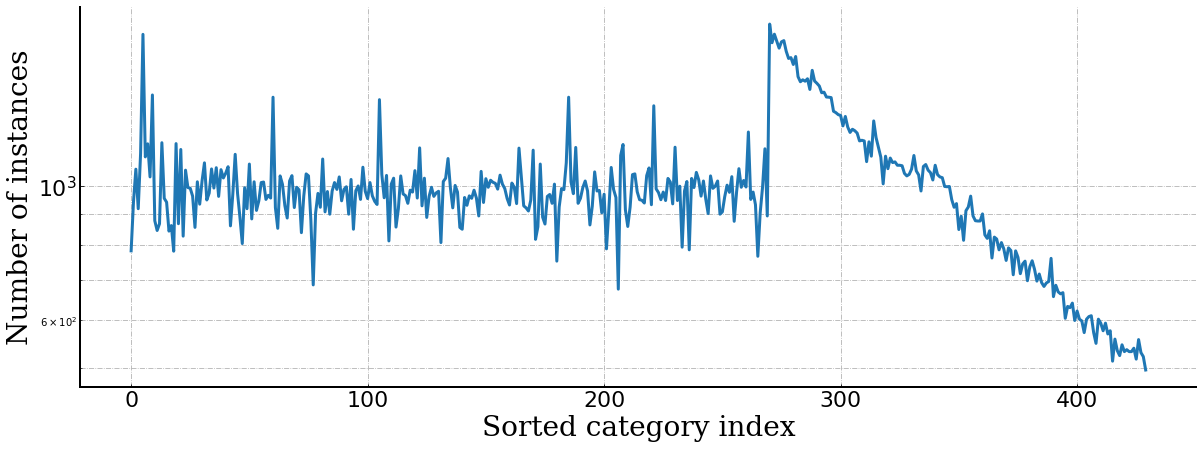

In [56]:
import matplotlib
%matplotlib inline
import pylab
import matplotlib.pyplot as plt
from matplotlib.ticker import  MultipleLocator
# matplotlib.use('Agg')

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
pylab.rcParams['figure.figsize'] = (20.0, 7.0)

# x1=range(nBase+(Step-1)*nStep,nBase+Step*nStep)
x1=range(nBase+Step*nStep)
y1=ann_num_balanced
# y1=ann_num[-nStep:]

# x2=range(nBase+(Step-1)*nStep)
# y2=ann_num_replay

fig = plt.figure()
ax = fig.gca()

ymajorLocator = MultipleLocator(200)     
yminorLocator = MultipleLocator(100)       
ax.yaxis.set_major_locator(ymajorLocator)       
ax.yaxis.set_minor_locator(yminorLocator)
# ax.set_ylim([0,2000])
plt.plot(x1,y1, linewidth=3.0)
# plt.plot(x2,y2, linewidth=3.0)


plt.yscale('log') #choose log or not
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# 设置坐标标签字体大小

font1 = {'family':'serif','weight': 'normal','size': 28}
ax.set_xlabel('Sorted category index', font1)
ax.set_ylabel('Number of instances', font1)
# plt.legend(frameon=False)

plt.grid(linestyle='-.',which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细

In [57]:
len(iter_img_id_balanced_qry[0])

4

In [58]:
json.dump(iter_img_id_balanced_qry, open(os.path.join(save_path, 'lvis_indices_qry_step1_rand_balanced.json'), 'w'))
json.dump(iter_cls_id_balanced_qry, open(os.path.join(save_path, 'lvis_classes_qry_step1_rand_balanced.json'), 'w'))
